In [1]:
 #Perform transfer learning to predict pneumonia in a patient, given their chest x-ray data.

import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
# deep learning stuff
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3 # for transfer learning

Using TensorFlow backend.


In [2]:
#REPLACE is place holder for the kaggle user and the key
!pip install kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
api_token = {"username":"REPLACE ","key":"REPLACE "}
import json
import zipfile
import os
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:30<00:00, 102MB/s] 
100% 2.29G/2.29G [00:30<00:00, 80.5MB/s]


In [0]:
!unzip chest-xray-pneumonia -d /content 
!unzip chest_xray.zip -d /content

In [0]:
os.chdir('/content/chest_xray')

In [0]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

In [0]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [0]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0 # Normal class, image is okay
            elif nextDir in ['PNEUMONIA']:
                label = 1 #abnormal Image has pneumonia
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [0]:
TRAIN_DIR = "/content/chest_xray/train/"
TEST_DIR =  "/content/chest_xray/test/"

In [0]:
train = os.path.join(TRAIN_DIR)
test = os.path.join(TEST_DIR)

In [12]:
X_train, y_train = get_data(train)

100%|██████████| 3875/3875 [11:23<00:00,  4.58it/s]


In [13]:

X_test , y_test = get_data(test)

100%|██████████| 390/390 [00:56<00:00,  6.96it/s]


In [14]:
print(X_train.shape,'\n',X_test.shape)
print(y_train.shape,'\n',y_test.shape)

(5216, 150, 150, 3) 
 (624, 150, 150, 3)
(5216,) 
 (624,)


In [0]:
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [0]:
pneumonia_images = os.listdir(TRAIN_DIR + "PNEUMONIA")
Normal_images = os.listdir(TRAIN_DIR + "NORMAL")

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


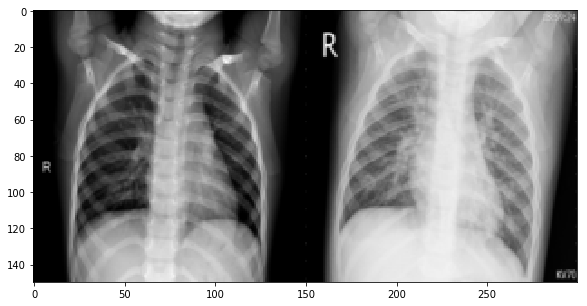

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


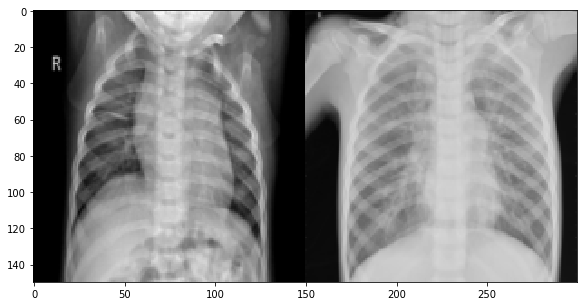

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


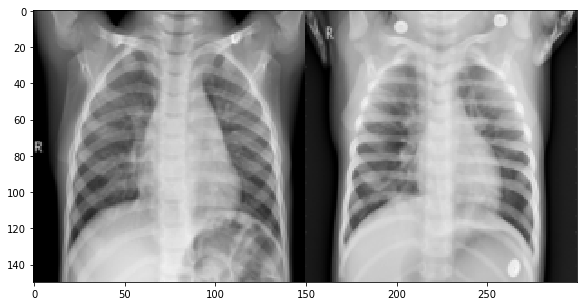

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


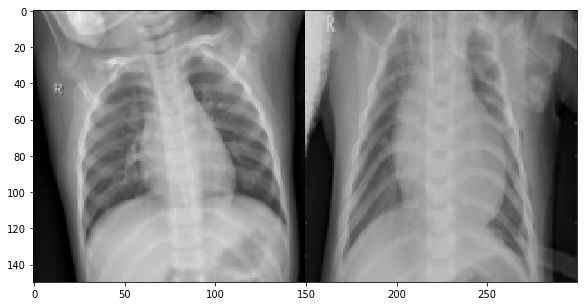

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


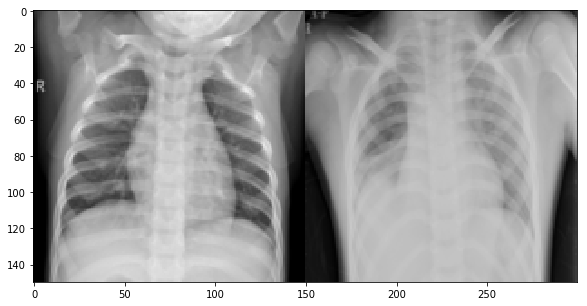

In [17]:
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"PNEUMONIA/"+pneumonia_images[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Normal_images[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [0]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [0]:
filepath="/content/chest_xray/transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:

X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [21]:
base_diagnosis_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150)) # dont include top to allow transfer 
# learning and allow custom clasification
x = base_diagnosis_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
base_diagnosis_model.load_weights("/content/inception_v3_weights_notop.h5")

In [23]:
model = Model(inputs=base_diagnosis_model.input, outputs=predictions)
#   for layer in base_model.layers:
#         layer.trainable = False
        
        
for layer in model.layers[:200]:
    layer.trainable = False
for layer in model.layers[200:]:
    layer.trainable = True
    
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 150, 150)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 74, 74)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 74, 74)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 74, 74)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [24]:
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5216 samples, validate on 624 samples
Epoch 1/10
5216/5216 [==============================] - 27s 5ms/step - loss: 0.2612 - acc: 0.8915 - val_loss: 2.2450 - val_acc: 0.6250

Epoch 00001: val_acc improved from -inf to 0.62500, saving model to /content/chest_xray/transferlearning_weights.hdf5
Epoch 2/10
5216/5216 [==============================] - 14s 3ms/step - loss: 0.1286 - acc: 0.9515 - val_loss: 3.0562 - val_acc: 0.6250

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_acc did not improve from 0.62500
Epoch 3/10
5216/5216 [==============================] - 13s 3ms/step - loss: 0.0637 - acc: 0.9801 - val_loss: 2.0804 - val_acc: 0.6250

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00003: val_acc did not improve from 0.62500
Epoch 4/10
5216/5216 [==============================] - 14s 3ms/step 

In [0]:
model.load_weights("transferlearning_weights.hdf5")

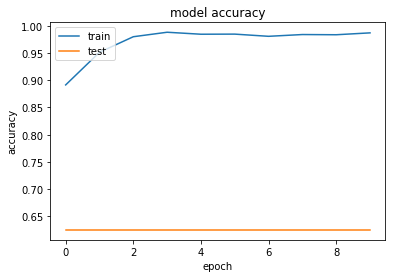

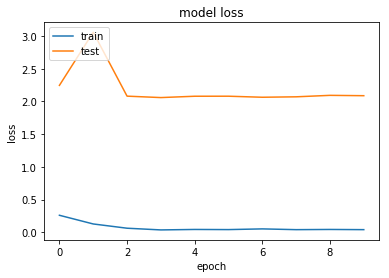

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
# Test accuracy
test_accu = history.history['acc']
print('The testing accuracy is :', test_accu[1]*100, '%')

The testing accuracy is : 95.14953987730061 %


In [0]:
pneumonia_test_images = os.listdir(TEST_DIR + "PNEUMONIA")
Normal_test_images = os.listdir(TEST_DIR + "NORMAL")

In [0]:
from keras.preprocessing import image
import keras as keras

 The test image is
Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


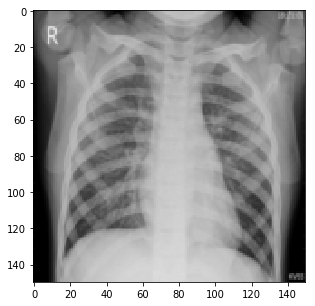

 The test image is
Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


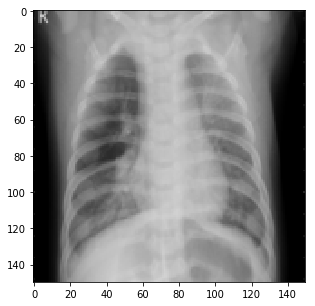

 The test image is
Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


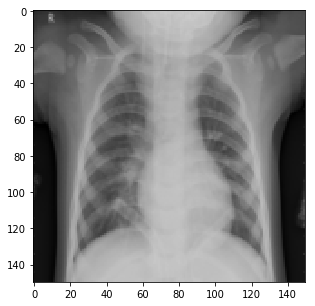

 The test image is
Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


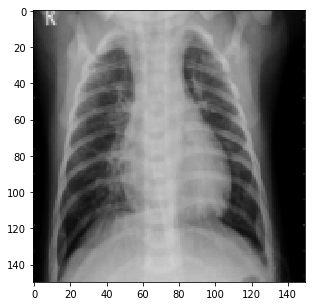

 The test image is
Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


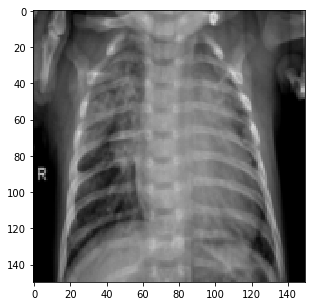

In [30]:
# making predictions on images from the testing dataset
def predictor(i):
    imagep1 = cv2.imread(TEST_DIR+"PNEUMONIA/"+pneumonia_test_images[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
   
    
    test_image = image.img_to_array(imagep1)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    
    if result[0][0] == 0:
      prediction = 'Normal'
      print(" The test image is")
      print(prediction)
    else:
      prediction = 'Pneumonia'
      print(" The test image is")
      print(prediction)
    
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(imagep1)
    plt.show()
for i in range(5,10):
    predictor(i)